## Pre-Processing_Dataset_2.py
Alfredo Andere

Input: E’ - mne data structure. <p>
Output: E - Dataset of epochs of 30 seconds of filtered and normalized data

In [1]:
import os
import numpy as np
import pandas as pd
import mne
from mne import preprocessing
import pickle
import random

In [2]:
### Actual example of data
def actual_data():
    """This unpickles the real data example prepared by Ana """
    pickle_off = open('data1.pkl', 'rb')
    print(pickle_off)
    raw = pickle.load(pickle_off)
    pickle_off.close()
    
    return raw
    

In [3]:
### Toy data to work with
def toy_data():
    """gives me some toy data to test with"""
    sample_data_folder = mne.datasets.sample.data_path()
    sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
    raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
    return raw

#### Divide into 30s samples
Input: E’ - a mne data structure of n number of recordings and t seconds each. <p>
Output: E - dataset of epochs e of 30 seconds but temporally ordered. 
        #epochs = |E’| = (n * t) / 30

In [4]:
def _create_events(raw, epoch_length):
    """Create events to split raw into epochs."""
    file_length = raw.n_times
    first_samp = raw.first_samp
    sfreq = raw.info['sfreq']
    n_samp_in_epoch = int(epoch_length * sfreq)

    n_epochs = int(file_length // n_samp_in_epoch)

    events = []
    for i_epoch in range(n_epochs):
        events.append([first_samp + i_epoch * n_samp_in_epoch, int(0), int(0)])
    events = np.array(events)
    return events


def divide_epochs(raw, e_len):
    """ Divides the mne dataset into many samples of length e_len seconds.
    
    Args:
        E: mne data structure
        e_len: (int seconds) length of each sample
        
    Returns:
        epochs: mne data structure of (experiment length * users) / e_len """
    if raw.times[-1] >= e_len:
        events = _create_events(raw, e_len)
    print(events)
    epochs = mne.Epochs(raw, events=events, tmax=e_len, preload=True) 
    return epochs

#### Downsample to 128 Hz and 3 channels 	[for MASS = 256 Hz]
Input: E’  - a mne data structure sampled at a rate r’ > 128 Hz <p>
Output: E’ - a mne data structure sampled at a rate r of 128 Hz. 

In [5]:
def downsample(epochs, chs, Hz=128):
    """ Downsample the EEG epoch to Hz=128 Hz and to only 
        include the channels in ch.
    
        Args: 
            epochs: mne data structure sampled at a rate r’ > 128 Hz
            chs: list of the channels to keep
            Hz: Hz to downsample to (default 128 Hz)
        Returns
            E: a mne data structure sampled at a rate r of 128 Hz.
    """
    # ch_id = [epochs.ch_names.index(ch) for ch in chs]
    E = epochs.pick_types(eeg=True, selection=chs)
    E = E.resample(Hz, npad='auto')
    return E

#### Normalization by sample 
Input: E’ - dataset (ds) of mne epoch objects e
Output: E  ds of mne epoch objects normalized s.t <p>
        mean(e)= 0, var(e) = 1 eE <p>
Return E - Dataset of normalized e 
            

In [6]:
def _normalize(epoch):
    return (epoch - epoch.mean()) / epoch.var()

def normalization(epochs):
    """ Normalizes each epoch e s.t mean(e)=mean and var(e)=variance
    
        Args:
            epochs - Numpy structure of epochs
        
        Returns:
            epochs_n - mne data structure of normalized epochs (mean=0, var=1)
    """
    for i in range(epochs.shape[0]):
        epochs[i,:,:] = _normalize(epochs[i,:,:])
    
    return epochs

#### Return E - Dataset of labeled e 

In [7]:
def __main__1():
    SAMPLE_TIME = 30
    CHANNELS = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0141', 'MEG 0211']
    
    raw = toy_data() # switch to 
    raw.plot()
    print(f"raw info: {raw.info}")
    
    epochs = divide_epochs(raw, SAMPLE_TIME)
    epochs.plot()

    epochs = downsample(epochs, CHANNELS)
    epochs.plot()
    print(f"epochs info: {epochs.info}")
    
    epochs = epochs.get_data() # turns into NumPy Array
    
    print(f"mean: {epochs.mean()}")
    print(f"variance: {epochs.var()}")
    f_epochs = normalization(epochs)
    
    print()
    print("-------Info on Data ---------")
    print(f"epoch shape: {epochs.shape} = (epochs, channels, samples/p/channel (30sec * Hz))")
    print(f"sampling_rate: {epochs.shape[2] / 30}")
    print(f"mean: {epochs.mean()}")
    print(f"variance: {epochs.var()}")
    
    return f_epochs

Opening raw data file /Users/alfredoanderejr/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


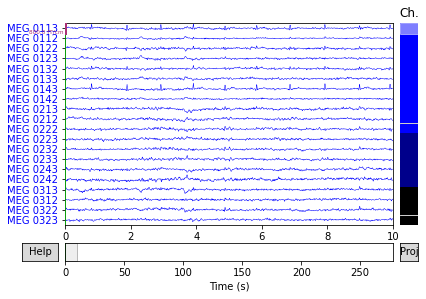

raw info: <Info | 19 non-empty fields
    bads : list | MEG 2443, EEG 053
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (GRAD: 204, MAG: 102, STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 376
    proc_history : list | 0 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.15374755859375 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experiment

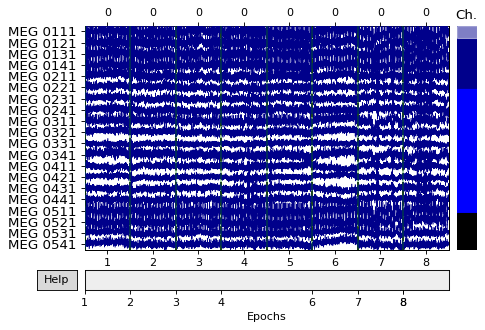

<ipython-input-7-37de2304c0b5>:13: RuntimeWarning: Projection vector "PCA-v1" has magnitude 0.06 (should be unity), applying projector with 5/102 of the original channels available may be dangerous, consider recomputing and adding projection vectors for channels that are eventually used. If this is intentional, consider using info.normalize_proj()
  epochs.plot()
<ipython-input-7-37de2304c0b5>:13: RuntimeWarning: Projection vector "PCA-v2" has magnitude 0.01 (should be unity), applying projector with 5/102 of the original channels available may be dangerous, consider recomputing and adding projection vectors for channels that are eventually used. If this is intentional, consider using info.normalize_proj()
  epochs.plot()
<ipython-input-7-37de2304c0b5>:13: RuntimeWarning: Projection vector "PCA-v3" has magnitude 0.31 (should be unity), applying projector with 5/102 of the original channels available may be dangerous, consider recomputing and adding projection vectors for channels that 

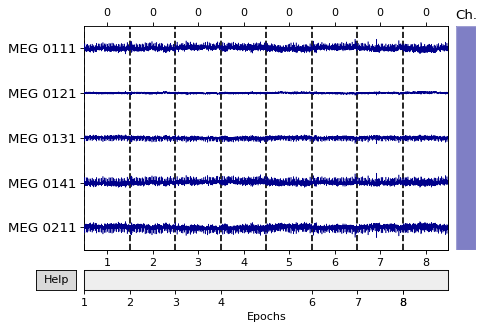

epochs info: <Info | 19 non-empty fields
    bads : list | 0 items
    ch_names : list | MEG 0111, MEG 0121, MEG 0131, MEG 0141, MEG 0211
    chs : list | 5 items (MAG: 5)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 5
    proc_history : list | 0 items
    projs : list | PCA-v1: on, PCA-v2: on, PCA-v3: on, ...
    sfreq : float | 128.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
  

In [8]:
data1 = __main__1()

In [9]:
data1.shape

(8, 5, 3867)

## Temporal Shuffling

In [10]:
def temporal_shuffling(epochs, T_pos, T_neg):
    """ Builds a self-supervised (temporal shuffling) dataset of epochs 
    
    Args:
        E - Numpy datset of time-series arrays
        T_pos - positive context to sample from
        T_neg - negative context to sample from
        
    Output:
        TS_dataset - Temporal Shuffling Dataset of dimensions (L, 4, s, c)
            L - # of samples = # of user * # of epochs per user * 6
            3 - sample1 + sample2 + sample3
            s - # of eeg channels in each sample
            c - Samples per channel = 30s * 128Hz
        TS_labels - Temporal Shuffling labels of dimensions (L, 1)
            for each y = {1: if sample1 < sample2 < sample3 and -1: otherwise}
            """
    np.random.seed(420) # If we live in a deterministic world, should we even seed our pseudorandoms?
    random.seed(69)
    
    total_samples = epochs.shape[0] * 6
    TS_dataset = np.empty((total_samples, 3, 5, 3867), int)
    TS_labels = np.empty((total_samples, 1))
    counter = 0
    ## need to add a variable here once our data is ready
    for user in range(1):
        for idx, sample1 in enumerate(epochs):
            for _ in range(3):
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                if idx-T_neg <= 0: # T_neg if (corners)
                    sample3_index = np.random.randint(idx+T_neg, epochs.shape[0])
                elif idx+T_neg >= epochs.shape[0]: # take care of low == high
                    sample3_index = np.random.randint(0, idx-T_neg)
                else:
                    sample3_index_1 = np.random.randint(idx+T_neg, epochs.shape[0])
                    sample3_index_2 = np.random.randint(0, idx-T_neg)
                    sample3_index = list([sample3_index_1, sample3_index_2])[int(random.uniform(0,1))]
                sample3 = epochs[sample3_index]
                
                if idx < sample2_index and sample2_index < sample3_index:
                    y = 1
                else:
                    y = -1

                TS_sample = np.array([sample1, sample2, sample3])
                TS_dataset[counter] = TS_sample
                TS_labels[counter] = y
                counter += 1
                
            for _ in range(3): # T_neg loop
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                sample3_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == sample3_index or sample3_index == idx: # should not be the same
                    sample3_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                sample3 = epochs[sample3_index]

                if idx < sample2_index and sample2_index < sample3_index:
                    y = 1
                else:
                    y = -1
                    
                TS_sample = np.array([sample1, sample2, sample3])
                TS_dataset[counter] = TS_sample
                TS_labels[counter] = y
                counter += 1

    return TS_dataset, TS_labels

In [11]:
def __mainTS__():
    TS_dataset, TS_labels = temporal_shuffling(data1, 3, 3)
    return TS_dataset, TS_labels  # The actual one will not return anything and will save the dataset to file

In [12]:
TS_dataset, TS_labels = __mainTS__()

In [13]:
TS_dataset.shape, TS_labels.shape

((48, 3, 5, 3867), (48, 1))

In [14]:
# Example
TS_dataset[0], TS_labels[0]

(array([[[-2153844920578, -2077897505412, -3072683454961, ...,
          -1572627234353,  -489558474616,  1137849321927],
         [-1592142370487, -1030433651187, -1042701362621, ...,
          -3335329480912, -2088959336947, -1459464000837],
         [-1371579443711, -1049340778470, -1092377179342, ...,
           1168973621201,  2585759486703,  3101020864998],
         [-2249788603677, -2065547384770, -2850109232780, ...,
          -1032844897618,   396469880785,  2190900398331],
         [-1354571392005,  -677467098856,   322791075673, ...,
           1100635294893,  1332514162591,   709396499781]],
 
        [[  823301463292,    65964265011, -1536162759309, ...,
          -1407157628452, -1866423698475, -2876701347757],
         [  104509601001,  -137054468456, -2468874864474, ...,
          -1200401365669, -1780565598926, -2709007609852],
         [ -568148132076,  -971822289426, -1773589297187, ...,
          -1764980251042, -2792156503294, -3815437589347],
         [ 1057478884

## Relative Positioning

In [15]:
def relative_positioning(epochs, T_pos, T_neg):
    """ Builds a self-supervised (relative positioning) dataset of epochs 
    
    Args:
        E - Numpy datset of time-series arrays
        T_pos - positive context to sample from
        T_neg - negative context to sample from
        
    Output:
        TS_dataset - Temporal Shuffling Dataset of dimensions (L, 3, s, c)
            L - # of samples = # of user * # of epochs per user * 6
            2 - sample1 + sample2
            s - # of eeg channels in each sample
            c - Samples per channel = 30s * 128Hz
        TS_labels - Temporal Shuffling labels of dimensions (1, L)
            for each y = {1: if |sample1-sample2| < T_pos and -1: if |sample1-sample2| > T_neg}
            """
    np.random.seed(420) # If we live in a deterministic world, should we even seed our pseudorandoms?
    random.seed(69)
    
    total_samples = epochs.shape[0] * 6
    RP_dataset = np.empty((total_samples, 2, 5, 3867), int)
    RP_labels = np.empty((total_samples, 1))
    counter = 0
    ## need to add a variable here once our data is ready
    for user in range(1):
        for idx, sample1 in enumerate(epochs):
            for _ in range(3): # Loop for T_pos
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                y = 1

                RP_sample = np.array([sample1, sample2])
                RP_dataset[counter] = RP_sample
                RP_labels[counter] = y
                counter += 1
                
            for _ in range(3): # Loop for T_neg
                if idx-T_neg <= 0: # T_neg if (corners)
                    sample2_index = np.random.randint(idx+T_neg, epochs.shape[0])
                elif idx+T_neg >= epochs.shape[0]: # take care of low == high
                    sample2_index = np.random.randint(0, idx-T_neg)
                else:
                    sample2_index_1 = np.random.randint(idx+T_neg, epochs.shape[0])
                    sample2_index_2 = np.random.randint(0, idx-T_neg)
                    sample2_index = list([sample2_index_1, sample2_index_2])[int(random.uniform(0,1))]
                sample2 = epochs[sample2_index]

                y = -1
                    
                RP_sample = np.array([sample1, sample2])
                RP_dataset[counter] = RP_sample
                RP_labels[counter] = y
                counter += 1

    return RP_dataset, RP_labels

In [16]:
def __mainRP__():
    RP_dataset, RP_labels = relative_positioning(data1, 3, 3)
    return RP_dataset, RP_labels  # The actual one will not return anything and will save the dataset to file

In [17]:
RP_dataset, RP_labels = __mainRP__()

In [18]:
RP_dataset.shape, RP_labels.shape

((48, 2, 5, 3867), (48, 1))

In [19]:
# Example
RP_dataset[0], RP_labels[0]

(array([[[-2153844920578, -2077897505412, -3072683454961, ...,
          -1572627234353,  -489558474616,  1137849321927],
         [-1592142370487, -1030433651187, -1042701362621, ...,
          -3335329480912, -2088959336947, -1459464000837],
         [-1371579443711, -1049340778470, -1092377179342, ...,
           1168973621201,  2585759486703,  3101020864998],
         [-2249788603677, -2065547384770, -2850109232780, ...,
          -1032844897618,   396469880785,  2190900398331],
         [-1354571392005,  -677467098856,   322791075673, ...,
           1100635294893,  1332514162591,   709396499781]],
 
        [[  823301463292,    65964265011, -1536162759309, ...,
          -1407157628452, -1866423698475, -2876701347757],
         [  104509601001,  -137054468456, -2468874864474, ...,
          -1200401365669, -1780565598926, -2709007609852],
         [ -568148132076,  -971822289426, -1773589297187, ...,
          -1764980251042, -2792156503294, -3815437589347],
         [ 1057478884